# Basic GNN Regressor on GREYC chemistry datasets
inspired and derived from https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
from tqdm import tqdm
import numpy as np

In [4]:
import torch
from greycdata.datasets import GreycDataset
#Choose Dataset between Acyclic, Alkane or MAO

dataset = GreycDataset(name='Acyclic',root='data/Acyclic')

Processing...
Done!


In [5]:
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: Acyclic:
Number of graphs: 183
Number of features: 15
Number of classes: 148


In [6]:
data = dataset[0]  # Get a graph object.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(data.x)

Number of nodes: 3
Number of edges: 4
Average node degree: 1.33
Has isolated nodes: False
Has self-loops: False
Is undirected: True
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.]])


In [7]:
dataset = dataset.shuffle()
ratio_train = .9
size_train = int(len(dataset)*ratio_train)
size_test = len(dataset)-size_train
train_dataset = dataset[:size_train]
test_dataset = dataset[size_train:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 164
Number of test graphs: 19


In [8]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(dataset[0].y)
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

tensor([185.9000])
Step 1:
Number of graphs in the current batch: 8
DataBatch(edge_index=[2, 116], bond_type=[116], bond_stereo=[116], x=[66, 15], y=[8], batch=[66], ptr=[9])

Step 2:
Number of graphs in the current batch: 8
DataBatch(edge_index=[2, 118], bond_type=[118], bond_stereo=[118], x=[67, 15], y=[8], batch=[67], ptr=[9])

Step 3:
Number of graphs in the current batch: 8
DataBatch(edge_index=[2, 98], bond_type=[98], bond_stereo=[98], x=[57, 15], y=[8], batch=[57], ptr=[9])

Step 4:
Number of graphs in the current batch: 8
DataBatch(edge_index=[2, 118], bond_type=[118], bond_stereo=[118], x=[67, 15], y=[8], batch=[67], ptr=[9])

Step 5:
Number of graphs in the current batch: 8
DataBatch(edge_index=[2, 108], bond_type=[108], bond_stereo=[108], x=[62, 15], y=[8], batch=[62], ptr=[9])

Step 6:
Number of graphs in the current batch: 8
DataBatch(edge_index=[2, 114], bond_type=[114], bond_stereo=[114], x=[65, 15], y=[8], batch=[65], ptr=[9])

Step 7:
Number of graphs in the current ba

In [19]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_add_pool


class MyGCN(torch.nn.Module):
    def __init__(self, input_channels,hidden_channels):
        super(MyGCN, self).__init__()
        self.conv1 = GCNConv(input_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        
        x = global_add_pool(x, batch) 
        x = self.lin(x)
        return x

model = MyGCN(input_channels=dataset.num_features,hidden_channels=64)
print(model)

MyGCN(
  (conv1): GCNConv(15, 64)
  (conv2): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=1, bias=True)
)


In [20]:
model = MyGCN(input_channels=dataset.num_features,hidden_channels=128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss(reduction="sum")

def my_mse(gt,pred):
    """
    Compute the sum of squared errors between gt and pred
    """
    return ((gt-pred)**2).sum()

def train():
    model.train()
    loss_epoch = 0.0
    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y.reshape(-1,1))  # Compute the loss.
        loss_epoch += loss.item()
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        loss_epoch += loss.item()
    return loss_epoch

def test(loader):
    model.eval()
    sse = 0.0
    nb = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)  
        sse += my_mse(out, data.y.reshape(-1,1))
    return sse

losses=[]

for epoch in tqdm(range(1, 1000)):
    loss = train()
    losses.append(loss)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [01:26<00:00, 11.57it/s]


33074.855377197266

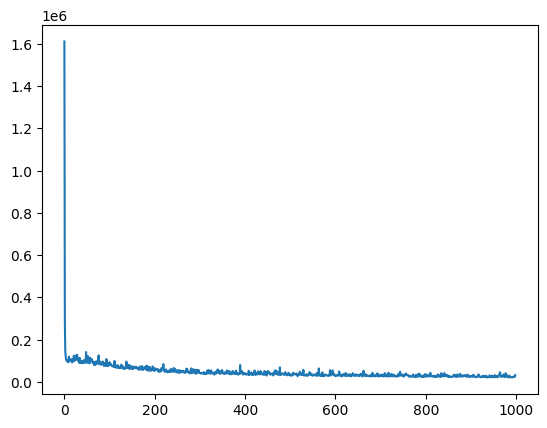

In [21]:
import matplotlib.pyplot as plt
plt.plot(losses)
losses[-1]

In [22]:
pred=np.zeros(size_train)
gt=np.zeros(size_train)
for i,data in enumerate(train_dataset):
    pred[i] = model(data.x, data.edge_index, torch.tensor([0])).item()
    gt[i] = data.y.item()
mae_train = np.mean(np.abs((gt-pred)))
print(f"MAE on train set :{mae_train:.2f}")

MAE on train set :7.35


In [23]:
pred=np.zeros(size_test)
gt=np.zeros(size_test)
for i,data in enumerate(test_dataset):
    pred[i] = model(data.x, data.edge_index, torch.tensor([0])).item()
    gt[i] = data.y.item()
mae_test = np.mean(np.abs((gt-pred)))
print(f"MAE on test set :{mae_test:.2f}")

MAE on test set :8.67


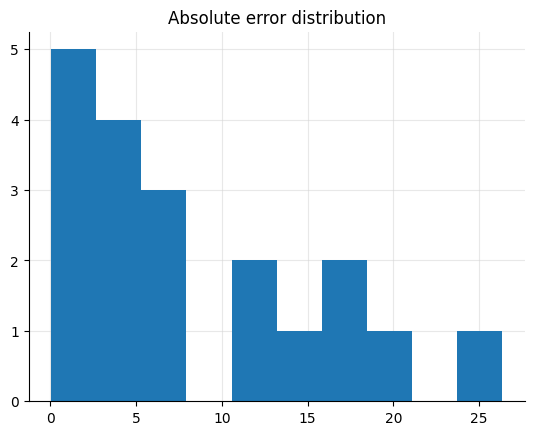

In [24]:

plt.grid(color="lightgray",alpha=.5,zorder=1)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title("Absolute error distribution")
plt.hist(np.abs(gt-pred),zorder=2);

# With GCN builtin model

In [64]:
from torch_geometric.nn import GCN
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import GIN

class GCNReadout(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels):
        super(GCNReadout, self).__init__()
        self.gcn = GIN(in_channels=input_channels, hidden_channels=hidden_channels, num_layers=2)
        self.fc = torch.nn.Linear(hidden_channels, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.gcn(x, edge_index)

        # Pooling
        x = global_add_pool(x, batch)

        # Readout layer
        x = self.fc(x)

        return x

model = GCNReadout(input_channels=dataset.num_features,hidden_channels=64)
print(model)

GCNReadout(
  (gcn): GIN(15, 64, num_layers=2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
model = GCNReadout(input_channels=dataset.num_features,hidden_channels=128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss(reduction="sum")

def my_mse(gt,pred):
    """
    Compute the sum of squared errors between gt and pred
    """
    return ((gt-pred)**2).sum()

def train():
    model.train()
    loss_epoch = 0.0
    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data)  # Perform a single forward pass.
        loss = criterion(out, data.y.reshape(-1,1))  # Compute the loss.
        loss_epoch += loss.item()
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        loss_epoch += loss.item()
    return loss_epoch

def test(loader):
    model.eval()
    sse = 0.0
    nb = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)  
        sse += my_mse(out, data.y.reshape(-1,1))
    return sse

losses=[]

for epoch in tqdm(range(1, 1000)):
    loss = train()
    losses.append(loss)

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 752/999 [02:07<01:01,  3.99it/s]

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
losses[-1]

In [ ]:
pred=np.zeros(size_train)
gt=np.zeros(size_train)
for i,data in enumerate(train_dataset):
    pred[i] = model(data)
    gt[i] = data.y.item()
mae_train = np.mean(np.abs((gt-pred)))
print(f"MAE on train set :{mae_train:.2f}")

In [ ]:
pred=np.zeros(size_test)
gt=np.zeros(size_test)
for i,data in enumerate(test_dataset):
    pred[i] = model(data).item()
    gt[i] = data.y.item()
mae_test = np.mean(np.abs((gt-pred)))
print(f"MAE on test set :{mae_test:.2f}")